In [57]:
from pymongo import MongoClient
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark import SparkContext
import matplotlib.pyplot as plt
from datetime import datetime

In [58]:
# Connect to MongoDB
client = MongoClient('mongodb://mongodb:27017/')
db = client.Youtube_Database
collection = db.youtube_data_us

# Print the first document
print(collection.find_one())

# Close the connection
client.close()

{'_id': ObjectId('6771509f1fb74dc5de3f2a04'), 'video_id': '3C66w5Z0ixs', 'title': 'I ASKED HER TO BE MY GIRLFRIEND...', 'publishedAt': '2020-08-11T19:20:14Z', 'channelId': 'UCvtRTOMP2TqYqu51xNrqAzg', 'channelTitle': 'Brawadis', 'categoryId': 22, 'trending_date': '2020-08-12T00:00:00Z', 'tags': 'brawadis|prank|basketball|skits|ghost|funny videos|vlog|vlogging|NBA|browadis|challenges|bmw i8|faze rug|faze rug brother|mama rug and papa rug', 'view_count': 1514614, 'likes': 156908, 'dislikes': 5855, 'comment_count': 35313, 'thumbnail_link': 'https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg', 'comments_disabled': False, 'ratings_disabled': False, 'description': 'SUBSCRIBE to BRAWADIS ▶ http://bit.ly/SubscribeToBrawadis\r\rFOLLOW ME ON SOCIAL\r▶ Twitter: https://twitter.com/Brawadis\r▶ Instagram: https://www.instagram.com/brawadis/\r▶ Snapchat: brawadis\r\rHi! I’m Brandon Awadis and I like to make dope vlogs, pranks, reactions, challenges and basketball videos. Don’t forget to subscribe and com

## Spark

In [59]:
spark_ = SparkSession.builder \
    .appName("company_database") \
    .config("spark.mongodb.input.uri", "mongodb://mongodb:27017/Company_Database") \
    .config("spark.mongodb.output.uri", "mongodb://mongodb:27017/Company_Database") \
    .config("spark.mongodb.input.uri", "mongodb://mongodb:27017/Youtube_Database") \
    .config("spark.mongodb.output.uri", "mongodb://mongodb:27017/Youtube_Database") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

## Importanção dos dados de cada pais

In [60]:
df_us = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_us").load()
df_br = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_br").load()
df_ca = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_ca").load()
df_fr = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_fr").load()
df_gb = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_gb").load()
df_in = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_in").load()
df_kr = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_kr").load()
df_mx = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Youtube_Database.youtube_data_mx").load()

## Importanção dos dados de empresa

In [61]:
df_dell = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.dell_data").load()
df_ibm = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.ibm_data").load()
df_intel = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.intel_data").load()
df_microsoft = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.microsoft_data").load()
df_nvidia = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.nvidia_data").load()
df_sony = spark_.read.format("mongo").option("uri", "mongodb://mongodb:27017/Company_Database.sony_data").load()

## Dicionario das empresas e seus nomes para posteriormente fazer a união dos dfs com a coluna company_name

In [62]:
dict_companies = {'companies': [
                 {'dataframe':df_dell, 'name': 'dell'},
                 {'dataframe':df_ibm, 'name': 'ibm'},
                 {'dataframe':df_intel, 'name': 'intel'},
                 {'dataframe':df_microsoft, 'name': 'microsoft'},
                 {'dataframe':df_nvidia, 'name': 'nvidia'},
                 {'dataframe':df_sony, 'name': 'sony'},  
                ]
            }

In [63]:
for company in dict_companies['companies']:
    company["dataframe"] = company["dataframe"].withColumn("company_name", lit(company["name"]))

In [64]:
df_companies = dict_companies['companies'][0]['dataframe'].union(dict_companies['companies'][1]['dataframe']).union(dict_companies['companies'][2]['dataframe']).union(dict_companies['companies'][3]['dataframe']).union(dict_companies['companies'][4]['dataframe']).union(dict_companies['companies'][5]['dataframe'])

In [65]:
df_us.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- tags: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- view_count: integer (nullable = true)



In [66]:
# Filtrar os videos por país relacionados a uma empresa

companies = ['nvidia', 'dell', 'ibm', 'intel', 'microsoft', 'sony']
countries_df = [df_us, df_br, df_ca, df_fr, df_gb, df_in, df_kr, df_mx]
countries = ['us', 'br', 'ca', 'fr', 'gb', 'in', 'kr', 'mx']

yt = {company: {} for company in companies}

def filter_df(df, company):
    filtered_df = df.filter(
        (col('description').contains(company)) |
        (col('title').contains(company)) |
        (col('channelTitle').contains(company))
    )
    return filtered_df.withColumn("company", lit(company))

for company in companies:
    for country, country_df in zip(countries, countries_df):
        filtered_data = filter_df(country_df, company)
        yt[company].setdefault(country, []).append(filtered_data)
        

## União dos df de cada pais num só

In [67]:
from functools import reduce

# Extract all DataFrames from the yt dictionary
all_dfs = [
    df 
    for company, country_data in yt.items() 
    for country, dfs in country_data.items() 
    for df in dfs
]

# Union all DataFrames using reduce
if all_dfs:
    df_yt = reduce(lambda df1, df2: df1.union(df2), all_dfs)
else:
    df_yt = None  # Handle case where there are no DataFrames

# Result: `df_yt` is the union of all DataFrames

In [68]:
df_yt.count()

28392

## Colunas existentes

In [69]:
df_yt.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- tags: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- company: string (nullable = false)



In [70]:
df_companies.count()

57226

## União dos videos de cada empresa

df_yt_companies - todos os videos das empresas a serem estudadas<br> 
df_all_companies - dados de todas as empreas a serem estudadas

## Estudo dos nulos

In [71]:
# YT
df_yt.select([count(when(col(c).isNull(), c)).alias(c) for c in df_yt.columns]).show()

+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+
|_id|categoryId|channelId|channelTitle|comment_count|comments_disabled|description|dislikes|likes|publishedAt|ratings_disabled|tags|thumbnail_link|title|trending_date|video_id|view_count|company|
+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+
|  0|         0|        0|           0|            0|                0|          0|       0|    0|          0|               0|   0|             0|    0|            0|       0|         0|      0|
+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+



In [72]:
duplicates = df_yt.groupBy(df_yt.columns).count().filter("count > 1")
duplicates.show()

+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+-----+
|_id|categoryId|channelId|channelTitle|comment_count|comments_disabled|description|dislikes|likes|publishedAt|ratings_disabled|tags|thumbnail_link|title|trending_date|video_id|view_count|company|count|
+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+-----+
+---+----------+---------+------------+-------------+-----------------+-----------+--------+-----+-----------+----------------+----+--------------+-----+-------------+--------+----------+-------+-----+



In [73]:
df_yt.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- tags: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- company: string (nullable = false)



In [74]:
df_companies.select([count(when(col(c).isNull(), c)).alias(c) for c in df_companies.columns]).show()

+---------+-----+----+----+---+----+------+---+------------+
|Adj Close|Close|Date|High|Low|Open|Volume|_id|company_name|
+---------+-----+----+----+---+----+------+---+------------+
|        0|    0|   0|   0|  0|   0|     0|  0|           0|
+---------+-----+----+----+---+----+------+---+------------+



In [75]:
duplicates = df_companies.groupBy("Date").count().filter("count > 1")
duplicates.show()

df_cleaned = df_companies.dropDuplicates(["Date"])

+----------+-----+
|      Date|count|
+----------+-----+
|2016-08-17|    7|
|2017-12-05|    7|
|2019-08-08|    7|
|2019-08-22|    7|
|2019-08-23|    7|
|2020-02-26|    7|
|2020-04-13|    7|
|2021-11-03|    7|
|2022-10-05|    7|
|2023-05-01|    7|
|2023-05-18|    7|
|2024-01-19|    7|
|2024-08-20|    5|
|2024-10-24|    5|
|2017-02-24|    7|
|2017-05-11|    7|
|2017-10-20|    7|
|2017-12-22|    7|
|2018-12-31|    7|
|2019-04-25|    7|
+----------+-----+
only showing top 20 rows



## Passar publishedAt e Date de string para data

In [76]:
df_companies.show(5)

+------------------+------------------+----------+------------------+------------------+------------------+-------+--------------------+------------+
|         Adj Close|             Close|      Date|              High|               Low|              Open| Volume|                 _id|company_name|
+------------------+------------------+----------+------------------+------------------+------------------+-------+--------------------+------------+
|11.263914108276367|12.067675590515137|2016-08-17|12.348319053649902|12.067675590515137| 12.20799732208252| 271519|{676ed5373c6e8c55...|        dell|
|11.198426246643066|11.997514724731444|2016-08-18|12.348319053649902|11.927353858947754|12.348319053649902|1767366|{676ed5373c6e8c55...|        dell|
|11.394889831542969| 12.20799732208252|2016-08-19| 12.20799732208252|11.969449996948242|11.983482360839844|4735900|{676ed5373c6e8c55...|        dell|
|11.434185028076172|12.250094413757324|2016-08-22|12.797348976135254| 11.95541763305664|12.067675590

In [77]:
df_yt = df_yt.withColumn(
    "publishedAt",
    to_date(df_yt.publishedAt, "yyyy-MM-dd'T'HH:mm:ss'Z'")
)


In [78]:
df_companies = df_companies.withColumn(
    "Date",
    to_date(df_companies.Date, "yyyy-MM-dd")
)


In [79]:
df_yt.show(5)

+--------------------+----------+--------------------+---------------+-------------+-----------------+--------------------+--------+------+-----------+----------------+--------------------+--------------------+--------------------+--------------------+-----------+----------+-------+
|                 _id|categoryId|           channelId|   channelTitle|comment_count|comments_disabled|         description|dislikes| likes|publishedAt|ratings_disabled|                tags|      thumbnail_link|               title|       trending_date|   video_id|view_count|company|
+--------------------+----------+--------------------+---------------+-------------+-----------------+--------------------+--------+------+-----------+----------------+--------------------+--------------------+--------------------+--------------------+-----------+----------+-------+
|{6771509f1fb74dc5...|        28|UCXuqSBlHAE6Xw-ye...|Linus Tech Tips|        20581|            false|Get 50% off your ...|    1398|121218| 2020-09-

In [80]:
df_companies.show(5)

+------------------+------------------+----------+------------------+------------------+------------------+-------+--------------------+------------+
|         Adj Close|             Close|      Date|              High|               Low|              Open| Volume|                 _id|company_name|
+------------------+------------------+----------+------------------+------------------+------------------+-------+--------------------+------------+
|11.263914108276367|12.067675590515137|2016-08-17|12.348319053649902|12.067675590515137| 12.20799732208252| 271519|{676ed5373c6e8c55...|        dell|
|11.198426246643066|11.997514724731444|2016-08-18|12.348319053649902|11.927353858947754|12.348319053649902|1767366|{676ed5373c6e8c55...|        dell|
|11.394889831542969| 12.20799732208252|2016-08-19| 12.20799732208252|11.969449996948242|11.983482360839844|4735900|{676ed5373c6e8c55...|        dell|
|11.434185028076172|12.250094413757324|2016-08-22|12.797348976135254| 11.95541763305664|12.067675590

In [81]:
df_yt.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- publishedAt: date (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- tags: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- company: string (nullable = false)



## Tags String to Array sem nulos

In [82]:
df_transformed = df_yt.withColumn("tags_arr", split(col("tags"), "\|")).drop("tags")

In [83]:
df_transformed.show(5)

+--------------------+----------+--------------------+---------------+-------------+-----------------+--------------------+--------+------+-----------+----------------+--------------------+--------------------+--------------------+-----------+----------+-------+--------------------+
|                 _id|categoryId|           channelId|   channelTitle|comment_count|comments_disabled|         description|dislikes| likes|publishedAt|ratings_disabled|      thumbnail_link|               title|       trending_date|   video_id|view_count|company|            tags_arr|
+--------------------+----------+--------------------+---------------+-------------+-----------------+--------------------+--------+------+-----------+----------------+--------------------+--------------------+--------------------+-----------+----------+-------+--------------------+
|{6771509f1fb74dc5...|        28|UCXuqSBlHAE6Xw-ye...|Linus Tech Tips|        20581|            false|Get 50% off your ...|    1398|121218| 2020-09-

In [84]:
df_transformed.select("tags_arr").show(5)

+--------------------+
|            tags_arr|
+--------------------+
|[nvidia, geforce,...|
|[gamersnexus, gam...|
|[NVIDIA, GeForce,...|
|[nvidia, geforce,...|
|[NVIDIA, GeForce,...|
+--------------------+
only showing top 5 rows



In [85]:
df_transformed.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- comments_disabled: boolean (nullable = true)
 |-- description: string (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- publishedAt: date (nullable = true)
 |-- ratings_disabled: boolean (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- title: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- video_id: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- company: string (nullable = false)
 |-- tags_arr: array (nullable = true)
 |    |-- element: string (containsNull = false)



In [86]:
df_companies.printSchema()

root
 |-- Adj Close: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Date: date (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- company_name: string (nullable = false)



In [87]:
df_transformed.count()

28392

## Plots

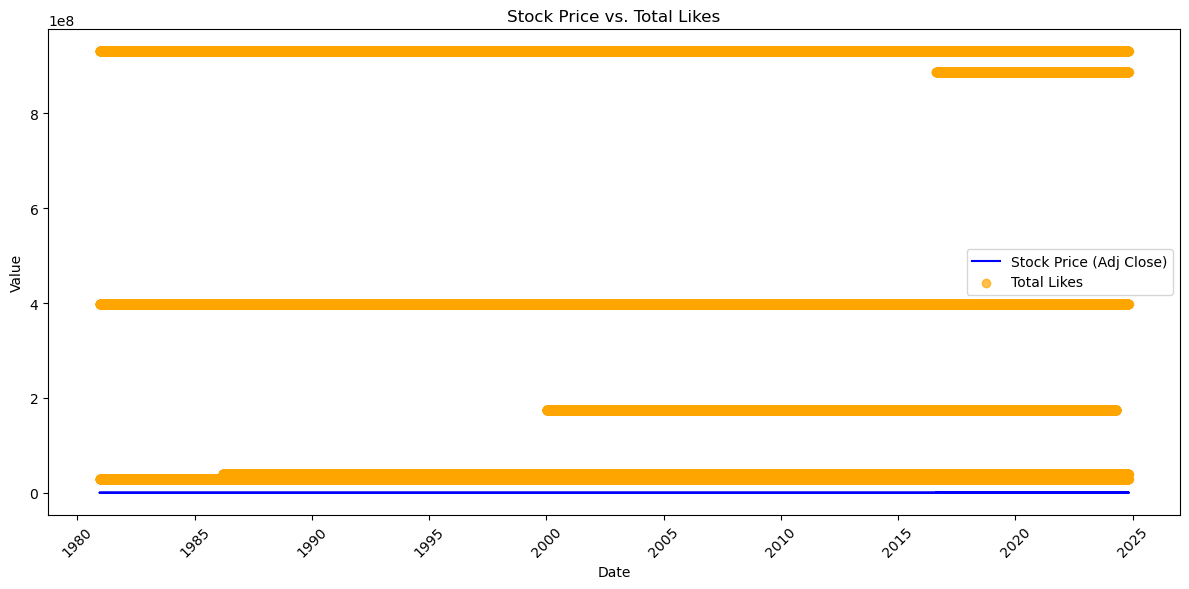

In [88]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, sum as spark_sum

# Aggregate video engagement metrics
df_yt_agg = df_transformed.groupBy("company").agg(
    spark_sum("likes").alias("total_likes"),
    spark_sum("view_count").alias("total_views")
)

# Join aggregated engagement metrics with stock data
df_combined = df_companies.join(
    df_yt_agg,
    df_companies["company_name"] == df_yt_agg["company"],
    how="inner"
).select("Date", "Adj Close", "company_name", "total_likes", "total_views")

# Collect data for plotting
plot_data = df_combined.toPandas()

# Plot Stock Price vs. Total Likes
plt.figure(figsize=(12, 6))
plt.plot(plot_data["Date"], plot_data["Adj Close"], label="Stock Price (Adj Close)", color="blue")
plt.scatter(plot_data["Date"], plot_data["total_likes"], label="Total Likes", color="orange", alpha=0.7)
plt.title("Stock Price vs. Total Likes")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_87/691248936.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(companies))


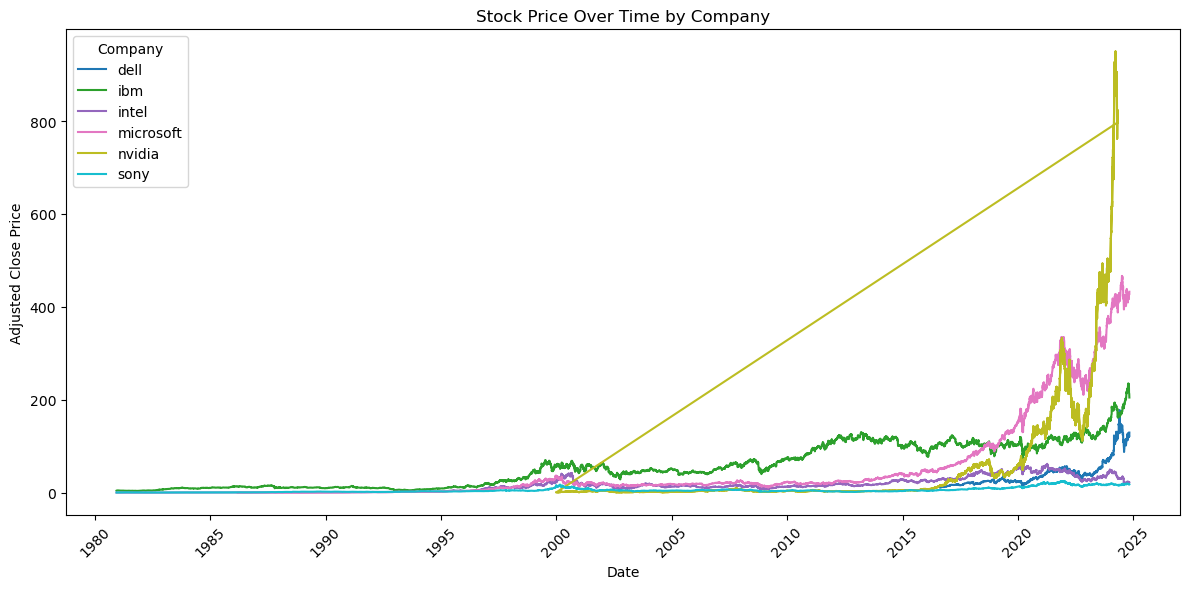

In [89]:
plot_data = df_combined.toPandas()

plt.figure(figsize=(12, 6))

companies = plot_data["company_name"].unique()
colors = plt.cm.get_cmap('tab10', len(companies))

for i, company in enumerate(companies):
    company_data = plot_data[plot_data["company_name"] == company]
    plt.plot(company_data["Date"], company_data["Adj Close"], label=company, color=colors(i))

plt.title("Stock Price Over Time by Company")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# AQUELA LINHA DA NVIDIA, QUE DEVIA CONTINUAR PARA A FRENTE (COMO AS OUTRAS) MANDOU O FODA SE AHHAHAHAAHA

/tmp/ipykernel_87/1280720576.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(companies))


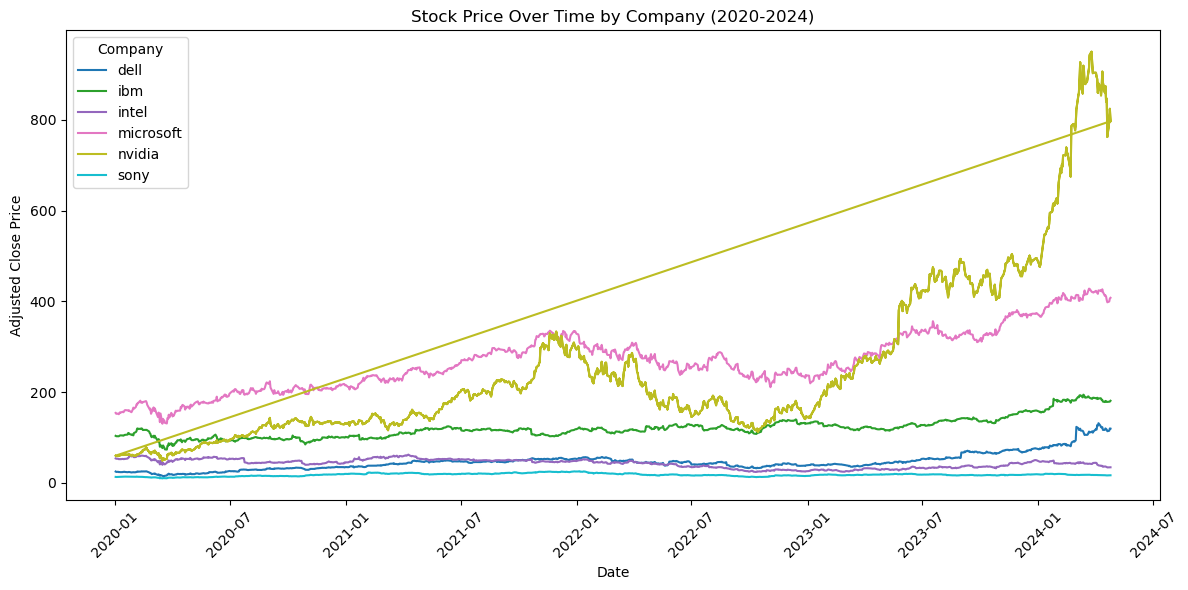

In [97]:
plot_data_filtered = df_combined.filter(
    (col("Date") >= "2020-01-01") & (col("Date") <= "2024-04-24")
)

plot_data = plot_data_filtered.toPandas()
plt.figure(figsize=(12, 6))
companies = plot_data["company_name"].unique()
colors = plt.cm.get_cmap('tab10', len(companies))

for i, company in enumerate(companies):
    company_data = plot_data[plot_data["company_name"] == company]
    plt.plot(company_data["Date"], company_data["Adj Close"], label=company, color=colors(i))

plt.title("Stock Price Over Time by Company (2020-2024)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [91]:
print(plot_data.columns)


Index(['Date', 'Adj Close', 'company_name', 'total_likes', 'total_views'], dtype='object')


In [92]:
df_yt_agg_by_date = df_yt.groupBy("company", "publishedAt").agg(
    F.sum("view_count").alias("total_views")
)


In [93]:
df_combined_yt = df_yt_agg_by_date.join(
    df_companies,
    df_yt_agg_by_date["company"] == df_companies["company_name"],
    how="inner"
).select("publishedAt", "total_views", "company", "Adj Close")


# ISTO NAO ME MOSTRA O TOP VIDEO EM TERMOS DE VIEWS POR DIA.... QUE RAIVAAAAAAAAAAAAAAA (a ideia era comparar se as views seguem o padrão de aumento dos stocks)

/tmp/ipykernel_87/2170658528.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(companies))


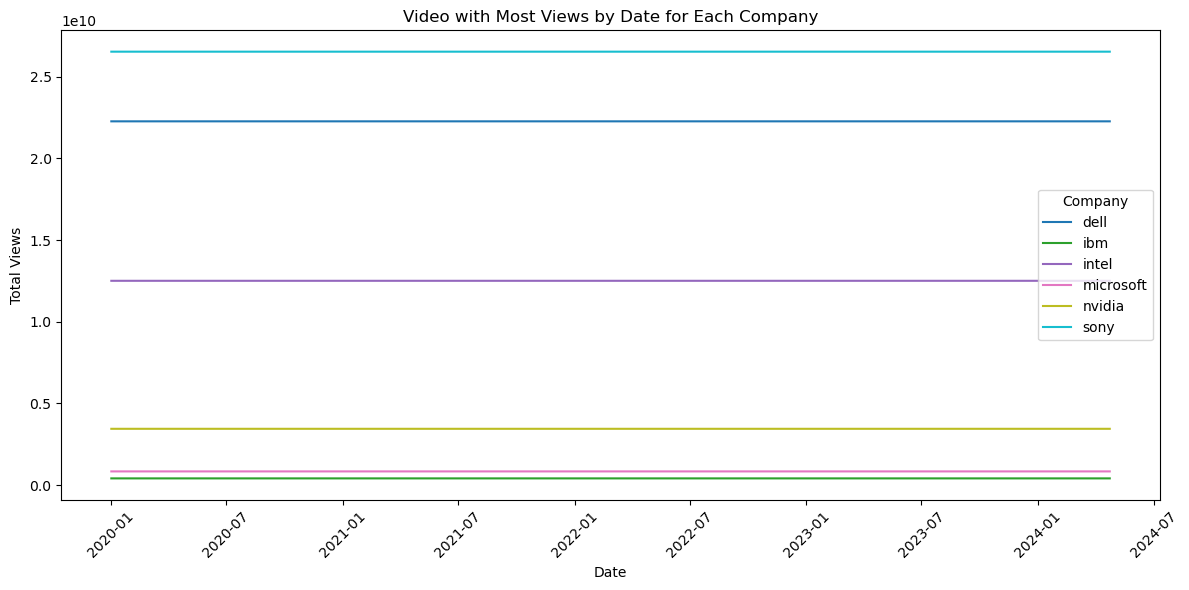

In [94]:
max_views_per_day = plot_data.loc[plot_data.groupby(['Date', 'company_name'])['total_views'].idxmax()]

plt.figure(figsize=(12, 6))

companies = max_views_per_day["company_name"].unique()
colors = plt.cm.get_cmap('tab10', len(companies))

for i, company in enumerate(companies):
    company_data = max_views_per_day[max_views_per_day["company_name"] == company]
    plt.plot(company_data["Date"], company_data["total_views"], label=company, color=colors(i))

plt.title("Video with Most Views by Date for Each Company")
plt.xlabel("Date")
plt.ylabel("Total Views")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


